In [107]:
# import pandas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score
from sklearn.decomposition import TruncatedSVD






import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Adult Dataset Part 1: Cleaning and Preparation

#### Objectives:
1. Preprocess the data and store the cleaned dataset as adult_clean.csv
2. Load clean dataset and test supervised/unsupervised models
    - Goal: Determine best model to predict if new entry earns >50k or <50k with supervised learning
    - Goal: Find insights and patterns in data using unspuervised learning
3. Apply k-folds cross validation
    - Goal: Evaluate robustness of results across different models.
    - Goal: Use and justify different error metrics


#### Summary of dataset

Datasource: https://archive.ics.uci.edu/ml/datasets/adult

Feature descrptions copied below from the UCI website:

- age: continuous. 
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
- fnlwgt: Continuous. A weighting assigned from the sampling process.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
- education-num: continuous. 
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
- sex: Female, Male. 
- capital-gain: continuous.
- capital-loss: continuous. 
- hours-per-week: continuous. 
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- target: >50K, <=50K.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#original data does not come with headers. add headers based on the documentation descrption
headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'target']

In [4]:
data = pd.read_csv('./data/adult.data', names = headers)
df = data.copy()

In [5]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


On first look, it appears there are no missing values. **However the dataset descrption indicates that missing values have been flled with '?'.** Figure out what to do here :)

In [6]:
for col in df.columns:
    if (df[col].dtype == 'O') and (df[col].str.contains(' ?', regex=False).any()):
        print(col)
        df[col] = df[col].replace(' ?', np.nan)

workclass
occupation
native-country


In [7]:
df[['occupation', 'workclass', 'native-country']].isna().sum()

occupation        1843
workclass         1836
native-country     583
dtype: int64

Before deciding **how to deal with the missing values want to know how they influence the data**. For example, if workclass and occupation for example both have missing values (in the same tuple) it would be reasonable to drop the data.

In [8]:
#code

In [12]:
df[['occupation', 'native-country']].isnull().all(1).sum()

27

In [13]:
df[['workclass', 'native-country']].isnull().all(1).sum()

27

In [14]:
df[['workclass', 'occupation']].isnull().all(1).sum()

1836

In [80]:
df.shape

(32561, 15)

**What % of the dataset do nans represent?** What is the **best approach** for dealing with the nan's?

In [15]:
df.isna().sum() / df.shape[0] * 100

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    1.790486
target            0.000000
dtype: float64

In [93]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [17]:
cat_features = []
num_features = []

In [18]:
df_target = df['target']
df = df.drop('target', axis=1)

In [19]:
for col in df.columns:
    if (df[col].dtype == 'O'):
        cat_features.append(col)
    else:
        num_features.append(col)

In [138]:
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [139]:
num_features

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

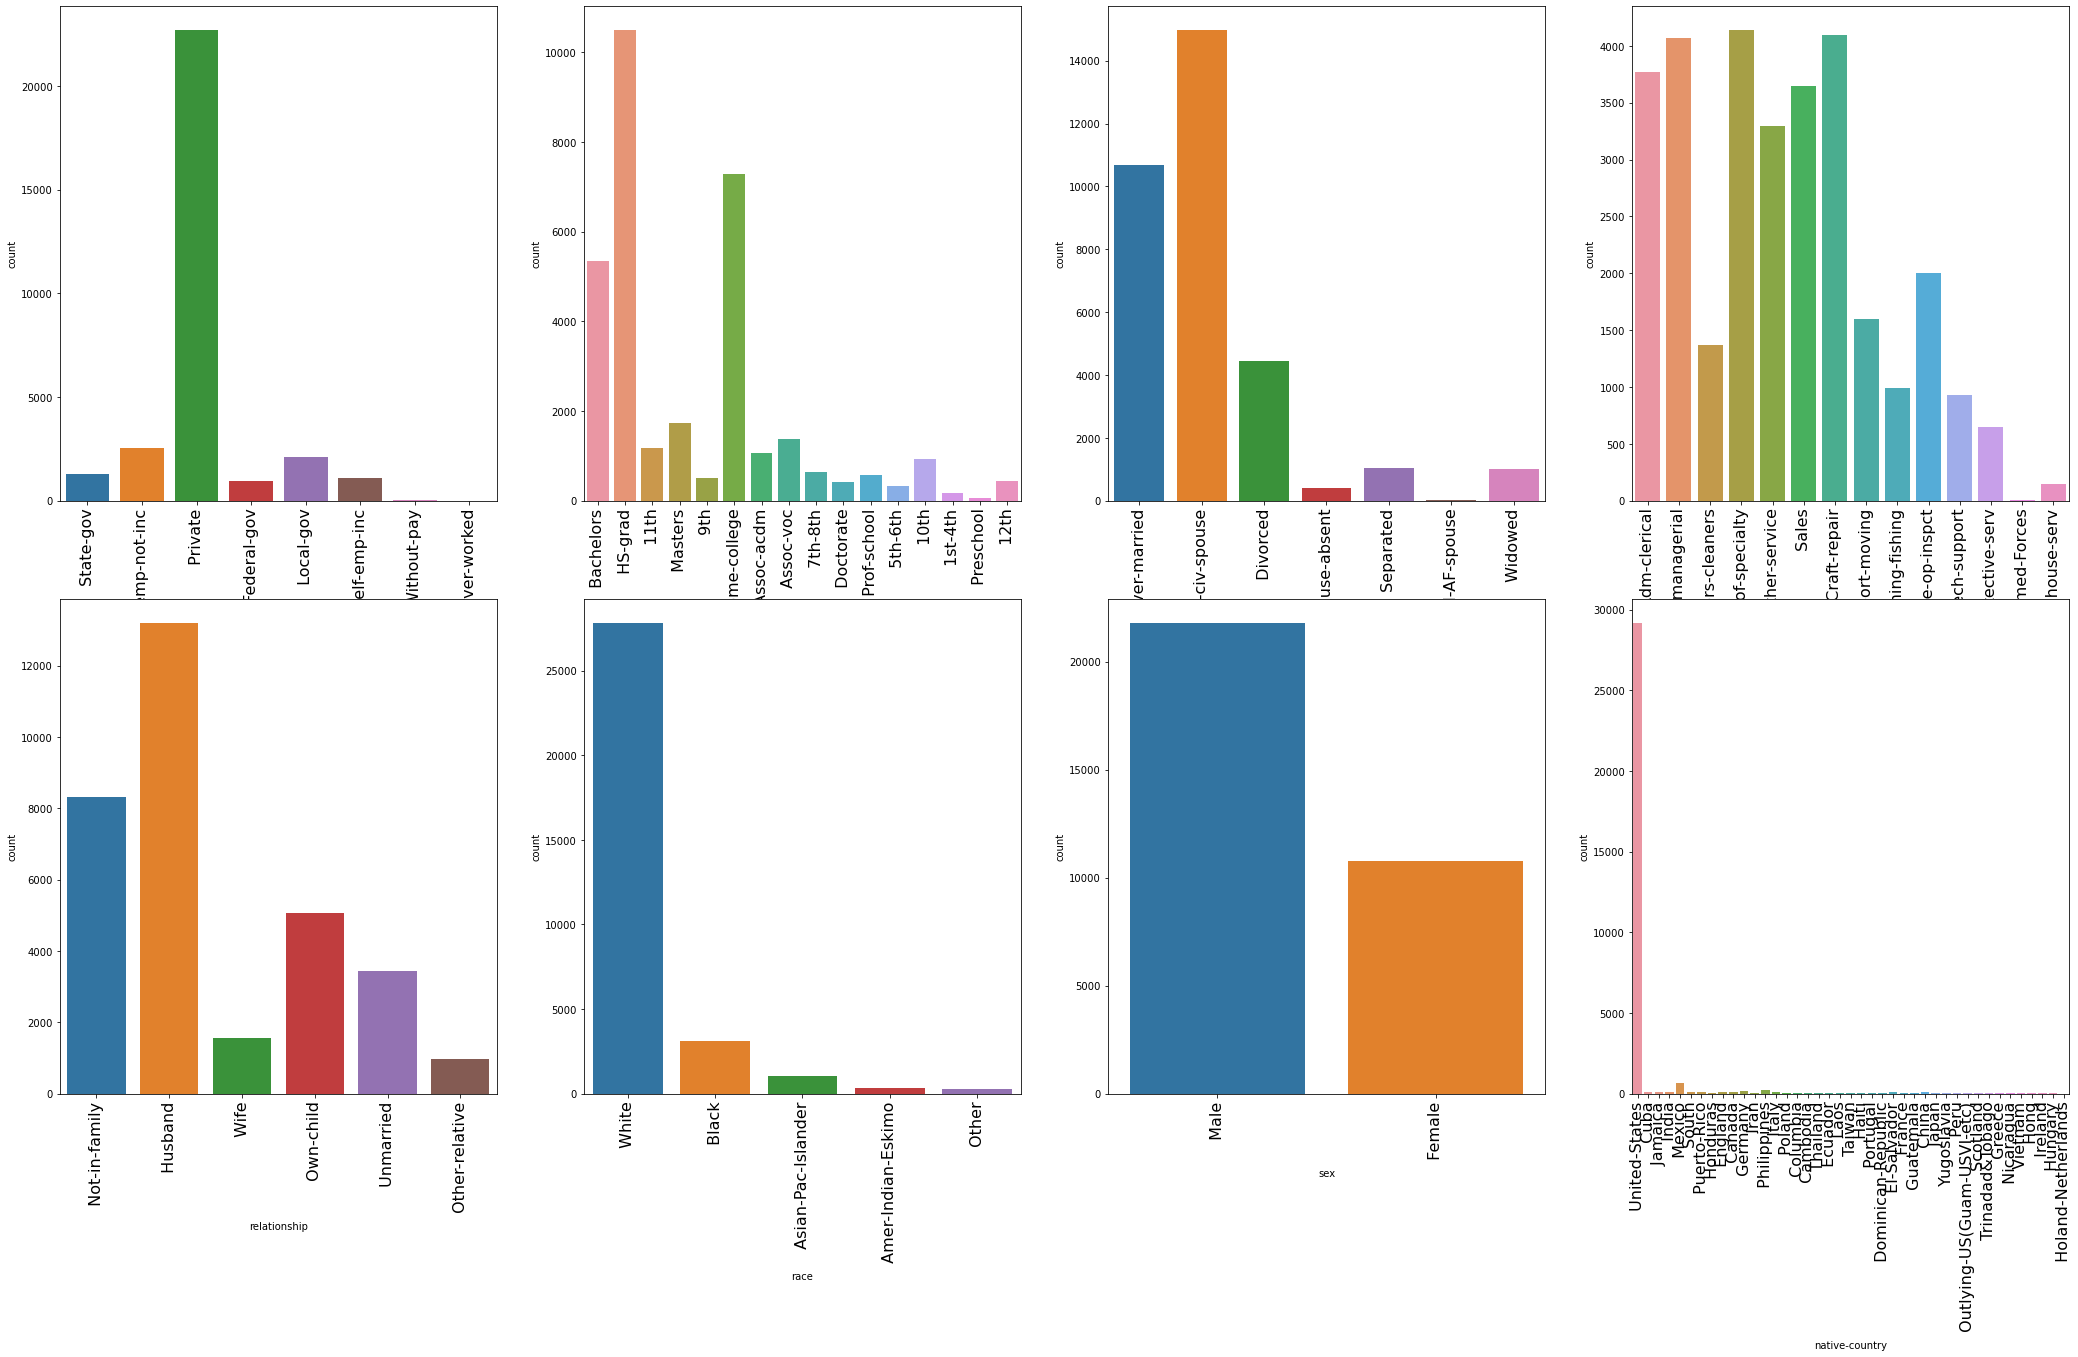

In [162]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(36, 20))
for i, col in enumerate(cat_features):
    if i > 3:
        sns.countplot(data=sorted(df), x=col, ax=ax[1,i-4])
        props = {"rotation" : 90, 'fontsize':16}
        plt.setp(ax[1,i-4].get_xticklabels(), **props)
    else:
        sns.countplot(data=sorted(df), x=col, ax=ax[0,i])
        props = {"rotation" : 90, 'fontsize':16}
        plt.setp(ax[0,i].get_xticklabels(), **props)



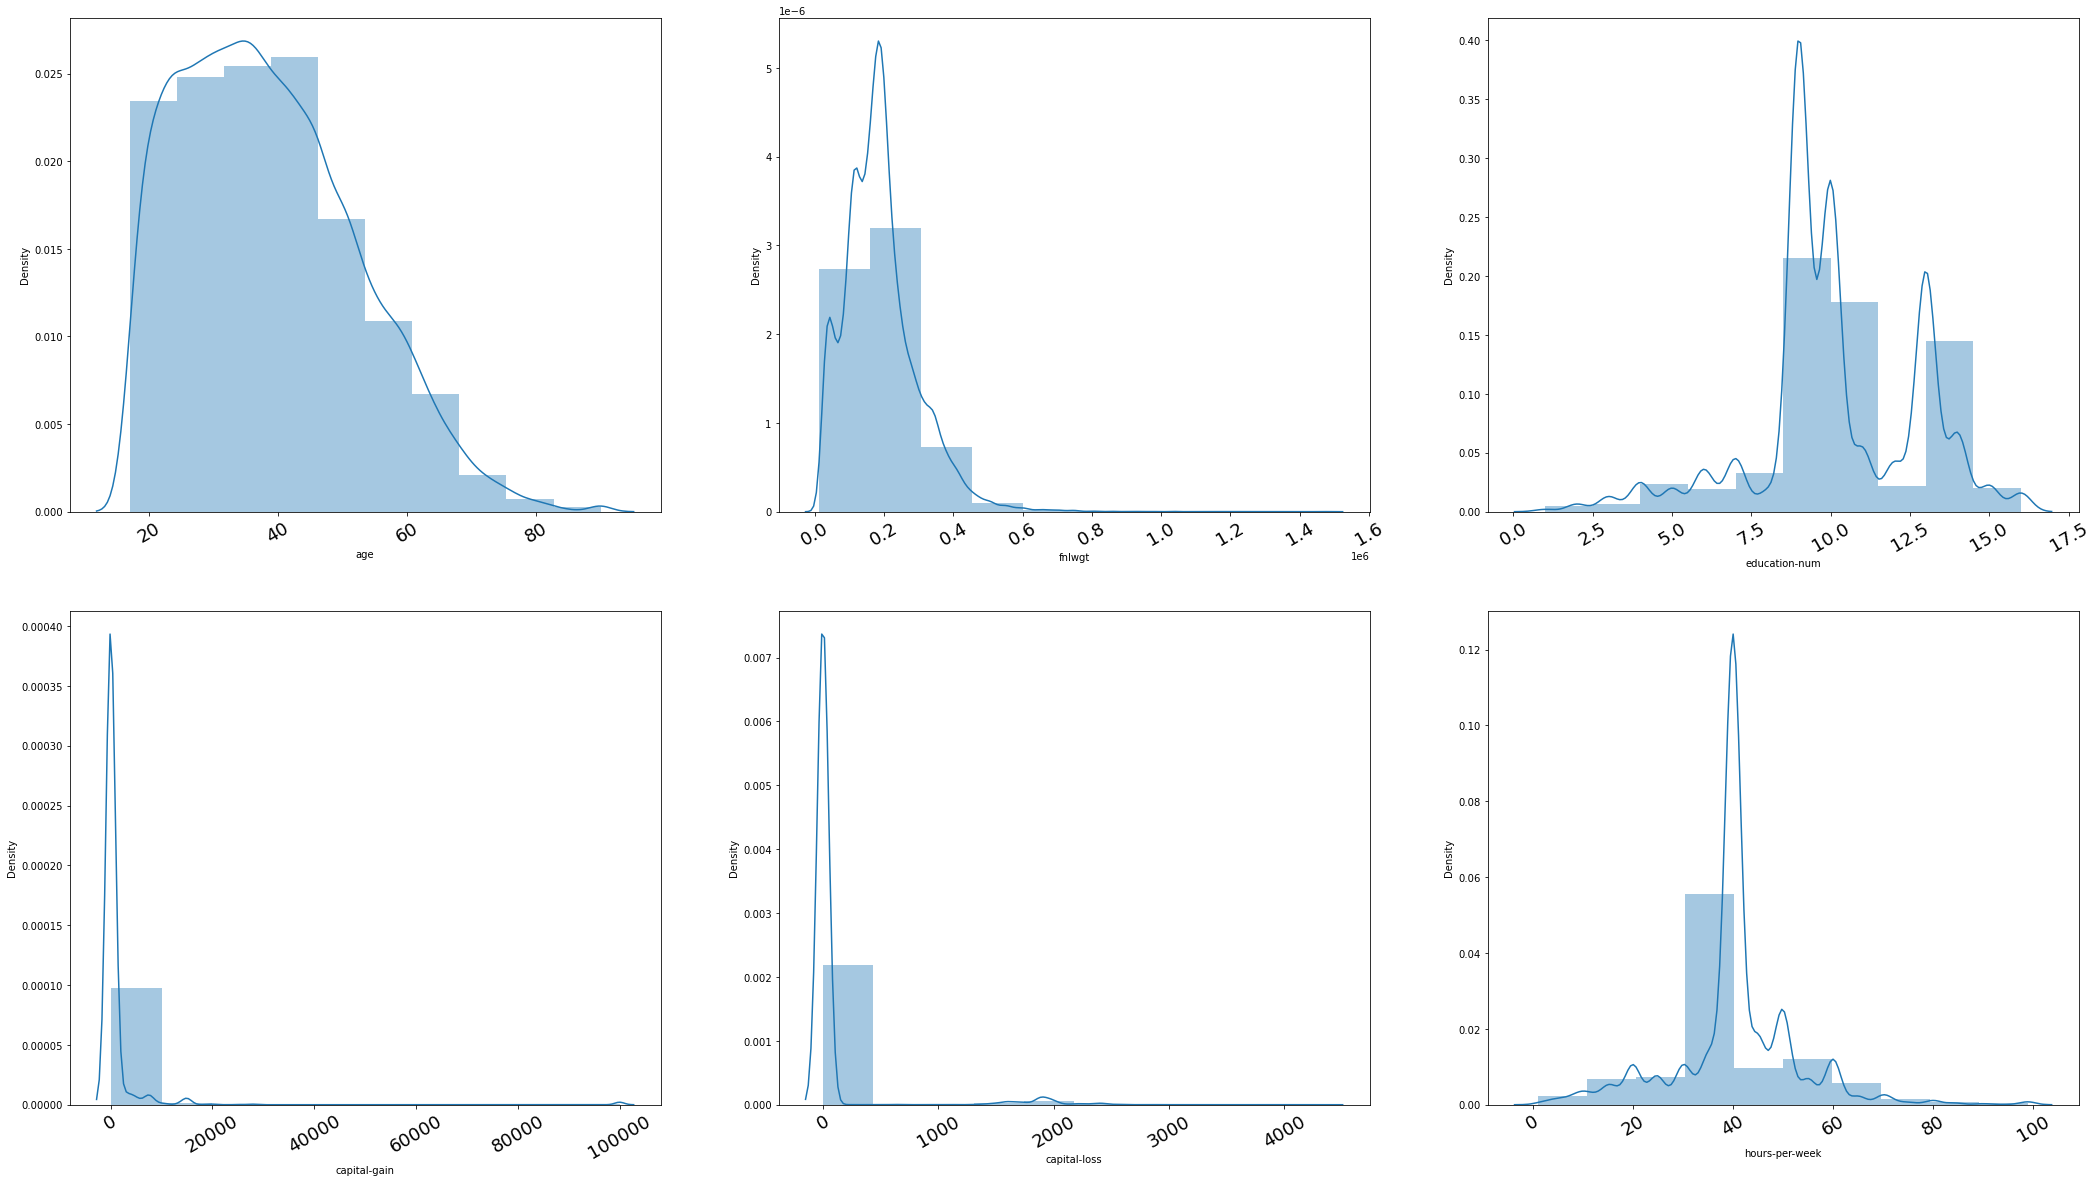

In [161]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(36, 20))
for i, col in enumerate(num_features):
    if i > 2:
        sns.distplot(df[col], ax=ax[1,i-3], bins=10)
        props = {"rotation" : 30, 'fontsize':18}
        plt.setp(ax[1,i-4].get_xticklabels(), **props)
    else:
        sns.distplot(df[col], ax=ax[0,i], bins=10)
        props = {"rotation" : 30, 'fontsize':18}
        plt.setp(ax[0,i].get_xticklabels(), **props)



#### Additional Steps:
1. Apply statistical tests to determine if dropping values changes the structure of the distribution in the workplace, occupation, and native-country categories i.e. t-test for differnce of modes. 
2. Compare filling the workplace and occupation columns with mode values and applying same statistical tests.

In [165]:
#train / test... you know the drill
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [28]:
X = df
y = df_target

In [29]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_dum = pd.get_dummies(X)
scaler = StandardScaler()
scaler.fit_transform(X_dum)

array([[ 0.03067056, -1.06361075,  1.13473876, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [ 0.83710898, -1.008707  ,  1.13473876, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [-0.04264203,  0.2450785 , -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       ...,
       [ 1.42360965, -0.35877741, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [-1.21564337,  0.11095988, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [ 0.98373415,  0.92989258, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266]])

In [91]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_dum)

In [33]:
pca.explained_variance_ratio_.cumsum()

array([0.99511364, 0.99998548, 0.99999997, 0.99999999])

In [100]:
X_dum

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,20,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [196]:
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [104]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [105]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [106]:
svc.score(X_test, y_test)

0.798710271764164

In [51]:
numeric_transformer = Pipeline(steps=[('pca', PCA(n_components=4)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [52]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
        ])


In [98]:
pipe = make_pipeline(preprocessor, SVC())

In [ ]:
pipe.fit(X_train, y_train)

In [78]:
pipe.score(X_test, y_test)

0.7683095347766007

In [50]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 
              'degree': [1,2,3,4,5], 'gamma':['scale', 'auto'],
               'C':[1, 10]}

In [80]:
clf = make_pipeline(preprocessor, TruncatedSVD(n_components=4),
                   GridSearchCV(SVC(),
                                 param_grid=parameters,
                                 cv=5,
                                 refit=True))

In [81]:
clf.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('pca',
                                                                   PCA(n_components=4)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',

In [245]:
clf[1].best_params_

{'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [83]:
clf[2].best_params_

{'C': 10, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [254]:
clf[1].best_score_

0.8544610851807131

In [84]:
clf[2].best_score_

0.8086226150000977

In [255]:
y_preds = clf.predict(X_test)

In [256]:
clf.score(X_test, y_test)

0.8581298940580377

In [85]:
clf.score(X_test, y_test)

0.8139106402579457

In [86]:
y_preds2 = clf.predict(X_test)

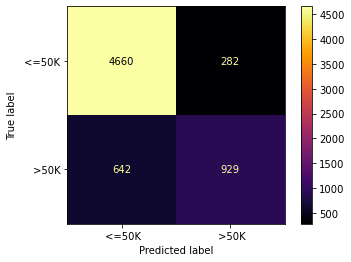

In [249]:
plot_confusion_matrix(clf, X_test, y_test, cmap='inferno');

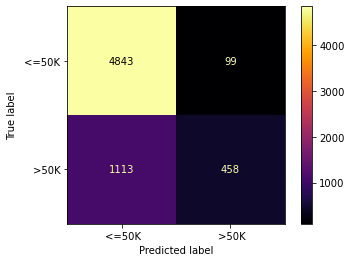

In [87]:
plot_confusion_matrix(clf, X_test, y_test, cmap='inferno');

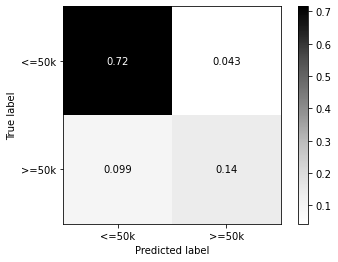

In [250]:
# print the confusion matrix
plot_confusion_matrix(clf, X_test, y_test, normalize='all', display_labels=['<=50k', '>=50k'], cmap='Greys');

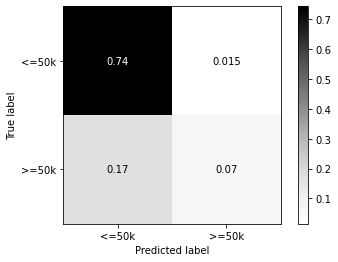

In [88]:
plot_confusion_matrix(clf, X_test, y_test, normalize='all', display_labels=['<=50k', '>=50k'], cmap='Greys');

In [259]:
y_preds

array([' <=50K', ' <=50K', ' >50K', ..., ' >50K', ' <=50K', ' <=50K'],
      dtype=object)

In [267]:
f1_score(y_test, y_preds, pos_label=" >50K")

0.6678648454349388

In [89]:
f1_score(y_test, y_preds2, pos_label=" >50K")

0.43045112781954886

In [268]:
recall_score(y_test, y_preds, average="binary", pos_label=" >50K")


0.5913430935709739

In [90]:
recall_score(y_test, y_preds2, average="binary", pos_label=" >50K")


0.2915340547422024

# Discussion of results